In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pymongo
import warnings
import re
warnings.filterwarnings("ignore")
username = "tagger-admin"
password = "tvaiadmin"
db_client = pymongo.MongoClient('104.198.62.226', username=username,
                                password=password,
                                authSource='tags',
                                authMechanism='SCRAM-SHA-256', port=27017).tags

import aerospike
config = {
    'hosts': [('35.228.136.58', 3000)]
}
client = aerospike.client(config).connect()
data_as_key = ("ids_to_validate", "data", "data")
tags_dictionary = client.get(data_as_key)[-1]['tags']
len(tags_dictionary)


# In[4]:


stats = {
            "Period": None,
    
            "Total processed": {
                "Validator": None,
                "Analyst": None,
                "Search": None,
                "Feed": None,
                "Dictionary": None
            },

            "Removed": {
                "Validator": None,
                "Analyst": None,
            },
    
            "Tagging":{
                
                "GutenTag": {
                    "RAW": {
                        "Validator": None,
                        "Analyst": None,                        
                    },
                    "DICT": {
                        "Validator": None,
                        "Analyst": None,                        
                    }
                },

                "Entities": {
                    "RAW": {
                        "Validator": None,
                        "Analyst": None,    
                    },
                    
                    "DICT": {
                        "Validator": None,
                        "Analyst": None,    
                    }                    
                },
                
                "Both Models": {
                    "RAW": {
                        "Validator": None,
                        "Analyst": None,    
                    },
                    
                    "DICT": {
                        "Validator": None,
                        "Analyst": None,    
                    }                    
                },
                
                "Analyst-Validator": {
                    "RAW": {
                        "Validator": None,
                        "Analyst": None,    
                    },
                    
                    "DICT": {
                        "Validator": None,
                        "Analyst": None,    
                    }                    
                },
                
                "TAGS NOT IN DICT": {
                    "Validator": None,
                    "Analyst": None,
                },
                                
            },


            "GutenShifts": {
                "Analyst": None,
            },

            "GutenIndustries": {
                "Analyst": None,
            },
        }


# # Processed

# In[5]:


def total_processed(startDate, endDate):


    totalProcessedValidator = db_client["tweets_pipeline_v2"].find({"$or": [{"status":"graphicone_search"}, {"status":"graphicone_feed"},
                                                                              {"status":"validated"}, {"status":"pipelined"}, 
                                                                              {"status":"deleted"}, {"status": "deleted_from_analytics"}], 
                                          'validated_timestamp': {'$gte': endDate, '$lte': startDate}
                                         }).count()

    totalProcessedAnalyst = db_client["tweets_pipeline_v2"].find({"$or": [{"status":"graphicone_search"}, {"status":"graphicone_feed"},
                                                                          {"status":"validated"}, {"status":"pipelined"}, 
                                                                          {"status":"deleted"}, {"status": "deleted_from_analytics"}], 
                                          'approved_timestamp': {'$gte': endDate, '$lte': startDate}
                                         }).count()

    totalProcessedSearch = db_client["tweets_pipeline_v2"].find({"$or": [{"status":"graphicone_search"}], 
                                          'approved_timestamp': {'$gte': endDate, '$lte': startDate}
                                         }).count()

    totalProcessedFeed = db_client["tweets_pipeline_v2"].find({"$or": [{"status":"graphicone_feed"}], 
                                          'approved_timestamp': {'$gte': endDate, '$lte': startDate}
                                         }).count()

    
    results = {
        "Validator": totalProcessedValidator, 
        "Analyst": totalProcessedAnalyst,
        "Search": totalProcessedSearch,
        "Feed": totalProcessedFeed,
    }
    
    return results


# # REMOVED

# In[6]:


def removed_stats(start_date, end_date):

    validator_removed_count = db_client["tweets_pipeline_v2"].find({"$or": [{"status":"deleted"}], 
                                                                          'validated_timestamp': {'$gte': end_date, '$lte': start_date}}).count()




    analyst_removed_count = db_client["tweets_pipeline_v2"].find({"$or": [{"status":"deleted_from_analytics"}], 
                                                                          'approved_timestamp': {'$gte': end_date, '$lte': start_date}}).count()

    result = {
        "Validator": validator_removed_count, 
        "Analyst": analyst_removed_count
    }
    return result


# # GutenTag

# In[7]:


def tags_simmilarity(model, person): 
    if len(model.union(person)) > 0:
        return len(model.intersection(person))/len(model.union(person))
    if len(model.union(person)) == 0 and len(model) == 0:
        return 1


# In[8]:


def dict_values(tags_list):
    new_tags = []
    tags_collector = []
    for tag in tags_list:
        if tag.lower() in tags_dictionary:
            if tags_dictionary[tag.lower()] != [0]:
                tags_collector += tags_dictionary[tag.lower()]     
        else:
            new_tags.append(tag.lower())
            tags_collector.append(tag.lower())
    return set(tags_collector), set(new_tags)


# In[9]:


def tagger_model_tags(start_date, end_date, guten_tag_labels):

    all_models_tager = []
    guten_tag_tager = []
    entity_tager = []
    
    all_models_tager_dict = []
    guten_tag_tager_dict = []
    entity_tager_dict = []
    
    new_tags_from_tagger = []
    
    for i in db_client["tweets_pipeline_v2"].find({"$or": [{"status":"validated"}, 
                                                           {"status":"graphicone_search"},{"status":"graphicone_feed"}, 
                                                           {"status": "deleted_from_analytics"}
                                                          ],
                                                   
                                                   'validated_timestamp': {'$gte': end_date, '$lte': start_date},
                                                   }).sort('validated_timestamp',pymongo.DESCENDING):
        
        tagger = set()
        guten_tag = set()
        entity = set()
        
        if "bert_tags" in i:
            guten_tag = set(i["bert_tags"])
            
        if "entity_prepared" in i:            
            try:
                entity = set(i["entity_prepared"])-set(guten_tag_labels)
            except Exception as err:
                pass
            
        if "confirmed_after_validate" in i:
            tagger = set(i["confirmed_after_validate"])
            tagger_after_dict, new_tags_tagger = dict_values(tagger)
        

        guten_tag_tager.append(tags_simmilarity(guten_tag, tagger.intersection(guten_tag_labels)))        
        entity_tager.append(tags_simmilarity(entity, tagger))        
        all_models_tager.append(tags_simmilarity(guten_tag.union(entity), tagger))
        
        guten_tag_tager_dict.append(tags_simmilarity(guten_tag, tagger_after_dict.intersection(guten_tag_labels)))        
        entity_tager_dict.append(tags_simmilarity(entity, tagger_after_dict))        
        all_models_tager_dict.append(tags_simmilarity(guten_tag.union(entity), tagger_after_dict))

        new_tags_from_tagger += list(new_tags_tagger)
                    
    results = {
        
        "RAW": {
            "GutenTag": np.array(guten_tag_tager).mean(),
            "Entity": np.array(entity_tager).mean(),
            "AllModels": np.array(all_models_tager).mean(),            
        },
        
        "DICT": {
            "GutenTag": np.array(guten_tag_tager_dict).mean(),
            "Entity": np.array(entity_tager_dict).mean(),
            "AllModels": np.array(all_models_tager_dict).mean(),            
        },        
        
        "TAGS NOT IN DICT": {
            "Validator": new_tags_from_tagger,
        }


    }
            
    return results


# In[10]:


def analyst_model_tags(start_date, end_date, guten_tag_labels):
    
    all_models_analyst = []
    guten_tag_analyst = []
    entity_analyst = []
    analyst_validator = []
    
    all_models_analyst_dict = []
    guten_tag_analyst_dict = []
    entity_analyst_dict = []
    analyst_validator_dict = []
    
    new_tags_from_analyst = []
    new_tags_from_tagger = []
    
    for i in db_client["tweets_pipeline_v2"].find({"$or": [{"status":"graphicone_search"},
                                                           {"status":"graphicone_feed"}],
                                                   'approved_timestamp': {'$gte': end_date, '$lte': start_date},
                                                   }).sort('approved_timestamp',pymongo.DESCENDING):
        
        analyst = set()
        guten_tag = set()
        entity = set()
        
        if "bert_tags" in i:
            guten_tag = set(i["bert_tags"])
            
        if "entity_prepared" in i:            
            try:
                entity = set(i["entity_prepared"])-set(guten_tag_labels)
            except Exception as err:
                pass
            
        if "confirmed_after_validate" in i:
            tagger = set(i["confirmed_after_validate"])
            tagger_after_dict, new_tags_tagger = dict_values(tagger)

            
        if "grafeed_confirmed" in i:
            analyst = set(i["grafeed_confirmed"])
            analyst_after_dict, new_tags_analyst = dict_values(analyst)
            

        guten_tag_analyst.append(tags_simmilarity(guten_tag, analyst.intersection(guten_tag_labels)))
        entity_analyst.append(tags_simmilarity(entity, analyst))
        all_models_analyst.append(tags_simmilarity(guten_tag.union(entity), analyst))
        analyst_validator.append(tags_simmilarity(tagger, analyst))
        
        guten_tag_analyst_dict.append(tags_simmilarity(guten_tag, analyst_after_dict.intersection(guten_tag_labels)))
        entity_analyst_dict.append(tags_simmilarity(entity, analyst_after_dict))
        all_models_analyst_dict.append(tags_simmilarity(guten_tag.union(entity), analyst_after_dict))
        analyst_validator_dict.append(tags_simmilarity(tagger_after_dict, analyst_after_dict))
        
        new_tags_from_analyst += list(new_tags_analyst)
        new_tags_from_tagger += list(new_tags_tagger)
    
    results = {
        "RAW": {
            "GutenTag": np.array(guten_tag_analyst).mean(),
            "Entity": np.array(entity_analyst).mean(),
            "Both": np.array(all_models_analyst).mean(),
            "Validator-Analyst": np.array(analyst_validator).mean(),                    
        },
        "DICT": {
            "GutenTag": np.array(guten_tag_analyst_dict).mean(),
            "Entity": np.array(entity_analyst_dict).mean(),
            "Both": np.array(all_models_analyst_dict).mean(),
            "Validator-Analyst": np.array(analyst_validator_dict).mean(),                    
        },        
        "TAGS NOT IN DICT": {
            "Validator": set(new_tags_from_tagger),
            "Analyst": set(new_tags_from_analyst)            
        }
    }
    
    return results


def analysts_model_shifts_industries(start_date, end_date):

    guten_shifts_analyst = []
    guten_industries_analyst = []
    
    for i in db_client["tweets_pipeline_v2"].find({"$or": [{"status":"graphicone_search"},                                 
                                                           {"status":"graphicone_feed"}],
                                                   "industries_from_bert": {"$exists": True},
                                                   "shifts_from_bert":{"$exists": True},
                                                   'approved_timestamp': {'$gte': end_date, '$lte': start_date},
                                                   }).sort('approved_timestamp',pymongo.DESCENDING):

        

        guten_industries = set(i["industries_from_bert"])
        guten_shifts = set(i["shifts_from_bert"])

        
        tagger_shifts = set([re.sub(r'[^\w\s]', '', cat) for cat in i["grafeed_shifts"] if cat is not None])
        tagger_industries = set([re.sub(r'[^\w\s]', '', cat) for cat in i["grafeed_industries"] if cat is not None])
        
        
        guten_shifts_analyst.append(tags_simmilarity(guten_shifts, tagger_shifts))        
        guten_industries_analyst.append(tags_simmilarity(guten_industries, tagger_industries))        
                    
    results = {
        
        "GutenShifts": {
            "Analyst": np.array(guten_shifts_analyst).mean(),
        },
        
        "GutenIndustries": {
            "Analyst": np.array(guten_industries_analyst).mean(),
        },

    }
            
    return results








# In[17]:


def get_stats(start_date, end_date, guten_tag_labels):
#     from_date = start_date
#     to_date = end_date
    processed_results = total_processed(start_date, end_date)
    removed_results = removed_stats(start_date, end_date)
    validator_model_results = tagger_model_tags(start_date, end_date, guten_tag_labels)
    analyst_model_results = analyst_model_tags(start_date, end_date, guten_tag_labels)    
    shifts_industries_model_results = analysts_model_shifts_industries(start_date, end_date)    
    
    stats["Period"] = {"Start": str(start_date), "End": str(end_date)}

    stats["Total processed"]["Validator"] = processed_results["Validator"]
    stats["Total processed"]["Analyst"] = processed_results["Analyst"]
    stats["Total processed"]["Search"] = processed_results["Search"]
    stats["Total processed"]["Feed"] = processed_results["Feed"]
    stats["Total processed"]["Dictionary"] = len(tags_dictionary)

    stats["Removed"]["Validator"] = round(removed_results["Validator"] / processed_results["Validator"],2)
    stats["Removed"]["Analyst"] = round(removed_results["Analyst"] / processed_results["Analyst"],2)

    #RAW
    stats["Tagging"]["GutenTag"]["RAW"]["Validator"] = round(validator_model_results["RAW"]["GutenTag"],2)
    stats["Tagging"]["Entities"]["RAW"]["Validator"] = round(validator_model_results["RAW"]["Entity"],2)
    stats["Tagging"]["Both Models"]["RAW"]["Validator"] = round(validator_model_results["RAW"]["AllModels"],2)

    stats["Tagging"]["GutenTag"]["RAW"]["Analyst"] = round(analyst_model_results["RAW"]["GutenTag"],2)
    stats["Tagging"]["Entities"]["RAW"]["Analyst"] = round(analyst_model_results["RAW"]["Entity"],2)
    stats["Tagging"]["Both Models"]["RAW"]["Analyst"] = round(analyst_model_results["RAW"]["Both"],2)
    stats["Tagging"]["Analyst-Validator"]["RAW"] = round(analyst_model_results["RAW"]["Validator-Analyst"],2)
    
    #SHIFTS & INDUSTRIES
    stats["GutenShifts"]["Analyst"] = round(shifts_industries_model_results["GutenShifts"]["Analyst"],2)
    stats["GutenIndustries"]["Analyst"] = round(shifts_industries_model_results["GutenIndustries"]["Analyst"],2)
    
    

    #DICT
    stats["Tagging"]["GutenTag"]["DICT"]["Validator"] = round(validator_model_results["DICT"]["GutenTag"],2)
    stats["Tagging"]["Entities"]["DICT"]["Validator"] = round(validator_model_results["DICT"]["Entity"],2)
    stats["Tagging"]["Both Models"]["DICT"]["Validator"] = round(validator_model_results["DICT"]["AllModels"],2)

    stats["Tagging"]["GutenTag"]["DICT"]["Analyst"] = round(analyst_model_results["DICT"]["GutenTag"],2)
    stats["Tagging"]["Entities"]["DICT"]["Analyst"] = round(analyst_model_results["DICT"]["Entity"],2)
    stats["Tagging"]["Both Models"]["DICT"]["Analyst"] = round(analyst_model_results["DICT"]["Both"],2)
    stats["Tagging"]["Analyst-Validator"]["DICT"] = round(analyst_model_results["DICT"]["Validator-Analyst"],2)

    #NEW TAGS
    stats["Tagging"]["TAGS NOT IN DICT"]["Validator"] = len(validator_model_results["TAGS NOT IN DICT"]["Validator"])
    stats["Tagging"]["TAGS NOT IN DICT"]["Analyst"] = len(analyst_model_results["TAGS NOT IN DICT"]["Analyst"])
    
                                                            
    return stats

In [2]:
def get_date_list(from_date, to_date, period):
    sdate = to_date   # start date
    edate = from_date  # end date


    delta = edate - sdate       # as timedelta

    dates_list = []
    sday = edate
    for i in range(0, delta.days + 1, period):
        if i > 0:        
            eday = edate - timedelta(days=i)
            dates_list.append([sday, eday])
            sday = eday
            
    return dates_list

In [8]:
import aerospike
config = {
    'hosts': [('35.228.136.58', 3000)]
}
client = aerospike.client(config).connect()
data_as_key = ("ids_to_validate", "data", "data")
bert_data_key = ("ids_to_validate", "data", "bert_tags")

tags_dictionary = client.get(data_as_key)[-1]['tags']
guten_tag_labels = client.get(bert_data_key)[-1]["gutenTag"]
print("tags_dictionary:", len(tags_dictionary))
print("guten_tag_labels:",len(guten_tag_labels))

tags_dictionary: 6006
guten_tag_labels: 254


In [12]:
data_for_show = []
for i in get_date_list(datetime.today(), datetime(2020, 1, 1), 1):
# for i in ConveyorMetrics.get_date_list(datetime.today(), datetime(2019, 11, 30), 1):
    start_date = i[0]
    end_date = i[1]
    try:
        stats_t = get_stats(start_date, end_date, guten_tag_labels)
#         print('Period', stats_t['Period'])
#         print('Total processed', stats_t['Total processed']['Validator'])
#         print('Removed', stats_t['Removed'])
#         print()
#         print('GutenTag', stats_t['Tagging']['GutenTag']['RAW']['Validator'])
#         print('Entities', stats_t['Tagging']['Entities']['RAW']['Validator'])
#         print('Both Models', stats_t['Tagging']['Both Models']['RAW']['Validator'])
#         print()
#         print('GutenShifts', stats_t['GutenShifts']['Analyst'])
#         print('GutenIndustries', stats_t['GutenIndustries']['Analyst'])
#         print()

        data_for_show.append([stats_t['Period']["Start"],stats_t['Period']["End"],
                              stats_t['Total processed']["Validator"],
                              stats_t['Total processed']["Analyst"],
                              stats_t['Tagging']['GutenTag']['RAW']['Validator'],
                              stats_t['Tagging']['Entities']['RAW']['Validator'],
                              stats_t['Tagging']['Both Models']['RAW']['Validator'],
                              stats_t['GutenShifts']['Analyst'],
                              stats_t['GutenIndustries']['Analyst']                              
                             ])
#         print(stats_t)
#         print()
    except Exception as err:
        print(err)
        pass

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


In [18]:
StatsModels = pd.DataFrame(data_for_show, columns = ["Start", "End", "Validator, N", "Analyst, N", 
                                       "GutenTag","Entities", "Both Models",
                                       "GutenShifts", "GutenIndustries"
                                      ])
StatsModels = StatsModels.drop(columns=["End"])
StatsModels

,Start,"Validator, N","Analyst, N",GutenTag,Entities,Both Models,GutenShifts,GutenIndustries
0,2020-04-23 14:10:20.079021,200,213,0.68,0.31,0.65,0.84,0.90
1,2020-04-22 14:10:20.079021,48,122,0.71,0.02,0.50,0.76,0.87
2,2020-04-21 14:10:20.079021,74,104,0.69,0.00,0.41,0.73,0.80
3,2020-04-20 14:10:20.079021,139,65,0.64,0.00,0.40,0.83,0.93
4,2020-04-18 14:10:20.079021,36,28,0.75,0.00,0.40,0.84,0.85
5,2020-04-16 14:10:20.079021,81,143,0.65,0.00,0.41,0.79,0.76
6,2020-04-15 14:10:20.079021,66,100,0.76,0.00,0.44,0.77,0.80
7,2020-04-14 14:10:20.079021,236,76,0.69,0.00,0.36,0.78,0.78
8,2020-04-13 14:10:20.079021,174,83,0.68,0.04,0.46,0.75,0.88
9,2020-04-12 14:10:20.079021,133,54,0.67,0.00,0.39,0.97,1.00


In [19]:
StatsModels.set_index("Start", inplace=True)

In [21]:
StatsModels

,"Validator, N","Analyst, N",GutenTag,Entities,Both Models,GutenShifts,GutenIndustries
Start,,,,,,,
2020-04-23 14:10:20.079021,200,213,0.68,0.31,0.65,0.84,0.90
2020-04-22 14:10:20.079021,48,122,0.71,0.02,0.50,0.76,0.87
2020-04-21 14:10:20.079021,74,104,0.69,0.00,0.41,0.73,0.80
2020-04-20 14:10:20.079021,139,65,0.64,0.00,0.40,0.83,0.93
2020-04-18 14:10:20.079021,36,28,0.75,0.00,0.40,0.84,0.85
2020-04-16 14:10:20.079021,81,143,0.65,0.00,0.41,0.79,0.76
2020-04-15 14:10:20.079021,66,100,0.76,0.00,0.44,0.77,0.80
2020-04-14 14:10:20.079021,236,76,0.69,0.00,0.36,0.78,0.78
2020-04-13 14:10:20.079021,174,83,0.68,0.04,0.46,0.75,0.88


In [35]:
StatsModels.index = StatsModels.index.astype('datetime64[ns]')

In [36]:
import matplotlib.pyplot as plt

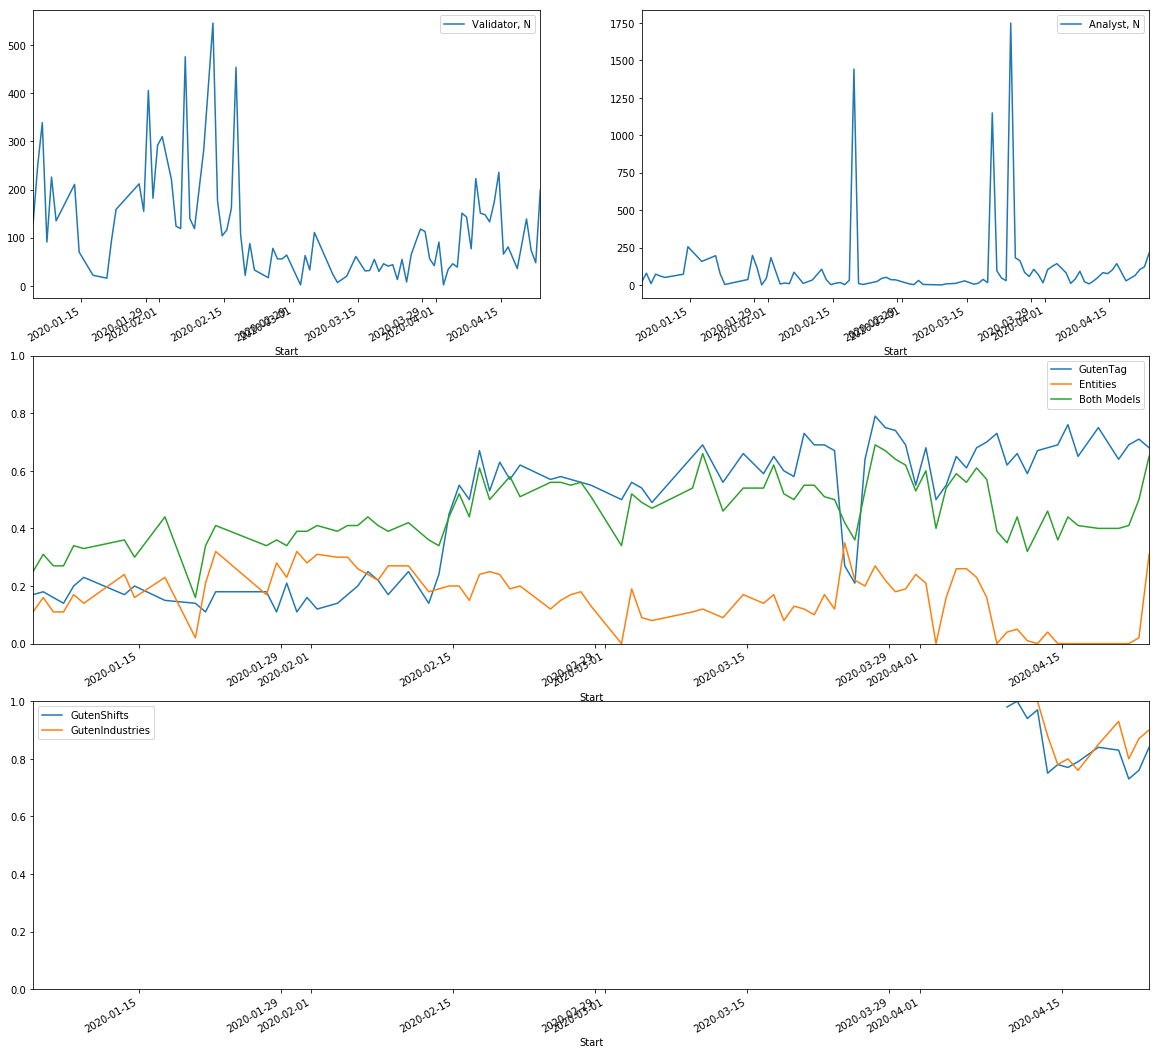

In [71]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
StatsModels["Validator, N"].plot() #no need to specify for first axis
plt.legend()
plt.subplot(3,2,2)
StatsModels["Analyst, N"].plot(ax=plt.gca())
plt.legend()
plt.subplot(3,1,2).set_ylim(ymin=0)
StatsModels["GutenTag"].plot(ax=plt.gca())
plt.legend()
plt.subplot(3,1,2).set_ylim(ymin=0)
StatsModels["Entities"].plot(ax=plt.gca())
plt.legend()
plt.subplot(3,1,2).set_ylim(ymin=0)
StatsModels["Both Models"].plot(ax=plt.gca())
plt.legend()
plt.subplot(3,1,3).set_ylim(ymin=0)
StatsModels["GutenShifts"].plot(ax=plt.gca())
plt.legend()
plt.subplot(3,1,3).set_ylim(ymin=0)
StatsModels["GutenIndustries"].plot(ax=plt.gca())
plt.legend()
plt.show()